In [14]:

import xml.etree.ElementTree as ET
import os
import pickle
import xmltodict
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [15]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET

# Define the paths to your image and annotation folders
path_image = "/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/Coral_images/image"
path_annotations = "/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/Coral_images/annotation"

# Initialize lists to store images and labels
images = []
labels = []

# Initialize counters for the classes
apal_count = 0
pseudodiploria_count = 0

# Set the desired balance ratio
desired_balance_ratio = 0.5  # 50% APAL, 50% Pseudodiploria

# Initialize counters for oversampling APAL and undersampling Pseudodiploria
oversample_apal = True
undersample_pseudodiploria = False

# Iterate through each image file in the image folder
for image_filename in os.listdir(path_image):
    if image_filename.lower().endswith(".jpg"):  # Check for image files
        image_path = os.path.join(path_image, image_filename)

        # Load the image using OpenCV
        image = cv2.imread(image_path)

        # Check if the image was loaded successfully
        if image is not None:
            # Resize the image to 224x224 if needed
            if image.shape[0] >= 224 and image.shape[1] >= 224:
                image = cv2.resize(image, (224, 224))
            else:
                print(f"Image dimensions are too small for resizing: {image_path}")

            # Load the corresponding label (XML file)
            xml_filename = os.path.splitext(image_filename)[0] + ".xml"
            xml_path = os.path.join(path_annotations, xml_filename)

            # Check if the XML file exists
            if os.path.exists(xml_path):
                # Parse the XML file to extract the label (you may need to adjust this based on your XML structure)
                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Find the "name" element and check if it exists
                name_element = root.find("object/name")
                if name_element is not None:
                    label = name_element.text  # Use .text to get the text content of the element
                    labels.append(label)

                    # Check the class label and balance the dataset
                    if label == "APAL":
                        apal_count += 1
                    elif label == "Pseudodiploria":
                        pseudodiploria_count += 1

                    # Append the image and label to the lists
                    images.append(image)

                else:
                    # Handle the case where the "name" element is missing
                    print(f"'name' element not found in XML file: {xml_path}")
            else:
                # Handle the case where the XML label file is missing
                print(f"XML label file not found for image: {image_path}")

# Calculate the oversampling and undersampling factors
if apal_count < pseudodiploria_count:
    oversample_factor = pseudodiploria_count / apal_count
    undersample_factor = 1.0
else:
    oversample_factor = 1.0
    undersample_factor = apal_count / pseudodiploria_count

# Apply oversampling and undersampling
oversample_apal = oversample_apal and apal_count < pseudodiploria_count
undersample_pseudodiploria = undersample_pseudodiploria and apal_count > pseudodiploria_count

oversampled_images = []
oversampled_labels = []

for i in range(len(images)):
    if labels[i] == "APAL" and oversample_apal:
        for _ in range(int(oversample_factor)):
            oversampled_images.append(images[i])
            oversampled_labels.append(labels[i])
    elif labels[i] == "Pseudodiploria" and undersample_pseudodiploria:
        if np.random.rand() < 1 / undersample_factor:
            continue

    oversampled_images.append(images[i])
    oversampled_labels.append(labels[i])

images = oversampled_images
labels = oversampled_labels

# Convert the lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Now, check the shapes and class distribution
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

# Check class distribution
unique_labels, class_counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, class_counts):
    print(f"Class: {label}, Count: {count}")

# Now you have a balanced dataset with the desired balance ratio.


Images shape: (1595, 224, 224, 3)
Labels shape: (1595,)
Class: APAL, Count: 812
Class: Pseudodiploria, Count: 783


In [16]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET

# Define the paths to your image and annotation folders
path_image = "/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/Coral_images/image"
path_annotations = "/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/Coral_images/annotation"

# Initialize lists to store images, labels, and masks
images = []
labels = []
masks = []

# Initialize counters for the classes
apal_count = 0
pseudodiploria_count = 0

# Set the desired balance ratio
desired_balance_ratio = 0.5  # 50% APAL, 50% Pseudodiploria

# Initialize counters for oversampling APAL and undersampling Pseudodiploria
oversample_apal = True
undersample_pseudodiploria = False

# Iterate through each image file in the image folder
for image_filename in os.listdir(path_image):
    if image_filename.lower().endswith(".jpg"):  # Check for image files
        image_path = os.path.join(path_image, image_filename)

        # Load the image using OpenCV
        image = cv2.imread(image_path)

        # Check if the image was loaded successfully
        if image is not None:
            # Resize the image to 224x224 if needed
            if image.shape[0] >= 224 and image.shape[1] >= 224:
                image = cv2.resize(image, (224, 224))
            else:
                print(f"Image dimensions are too small for resizing: {image_path}")

            # Load the corresponding label (XML file)
            xml_filename = os.path.splitext(image_filename)[0] + ".xml"
            xml_path = os.path.join(path_annotations, xml_filename)

            # Check if the XML file exists
            if os.path.exists(xml_path):
                # Parse the XML file to extract the label (you may need to adjust this based on your XML structure)
                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Initialize a binary mask for this image
                mask = np.zeros(image.shape[:2], dtype=np.uint8)

                # Find the "name" element and check if it exists
                name_element = root.find("object/name")
                if name_element is not None:
                    label = name_element.text  # Use .text to get the text content of the element

                    # Check the class label and balance the dataset
                    if label == "APAL":
                        apal_count += 1
                    elif label == "Pseudodiploria":
                        pseudodiploria_count += 1

                    # Find the polygon points and draw the mask
                    polygon = root.find("object/polygon")
                    if polygon is not None:
                        points = []
                        for pt in polygon.findall("pt"):
                            x = int(pt.find("x").text)
                            y = int(pt.find("y").text)
                            points.append((x, y))
                        points = np.array(points, dtype=np.int32)
                        cv2.fillPoly(mask, [points], 1)

                    # Append the image, label, and mask to the lists
                    images.append(image)
                    labels.append(label)
                    masks.append(mask)

                else:
                    # Handle the case where the "name" element is missing
                    print(f"'name' element not found in XML file: {xml_path}")
            else:
                # Handle the case where the XML label file is missing
                print(f"XML label file not found for image: {image_path}")

# Calculate the oversampling and undersampling factors
if apal_count < pseudodiploria_count:
    oversample_factor = pseudodiploria_count / apal_count
    undersample_factor = 1.0
else:
    oversample_factor = 1.0
    undersample_factor = apal_count / pseudodiploria_count

# Apply oversampling and undersampling
oversample_apal = oversample_apal and apal_count < pseudodiploria_count
undersample_pseudodiploria = undersample_pseudodiploria and apal_count > pseudodiploria_count

# Initialize lists to store oversampled data
oversampled_images = []
oversampled_labels = []
oversampled_masks = []

for i in range(len(images)):
    if labels[i] == "APAL" and oversample_apal:
        for _ in range(int(oversample_factor)):
            oversampled_images.append(images[i])
            oversampled_labels.append(labels[i])
            oversampled_masks.append(masks[i])
    elif labels[i] == "Pseudodiploria" and undersample_pseudodiploria:
        if np.random.rand() < 1 / undersample_factor:
            continue

    oversampled_images.append(images[i])
    oversampled_labels.append(labels[i])
    oversampled_masks.append(masks[i])

# Convert the lists to NumPy arrays
images = np.array(oversampled_images)
masks = np.array(oversampled_masks)
labels = np.array(oversampled_labels)

# Now, you have NumPy arrays for images, masks, and labels
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")
print(f"Labels shape: {labels.shape}")

# Check class distribution
unique_labels, class_counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, class_counts):
    print(f"Class: {label}, Count: {count}")


Images shape: (1595, 224, 224, 3)
Masks shape: (1595, 224, 224)
Labels shape: (1595,)
Class: APAL, Count: 812
Class: Pseudodiploria, Count: 783


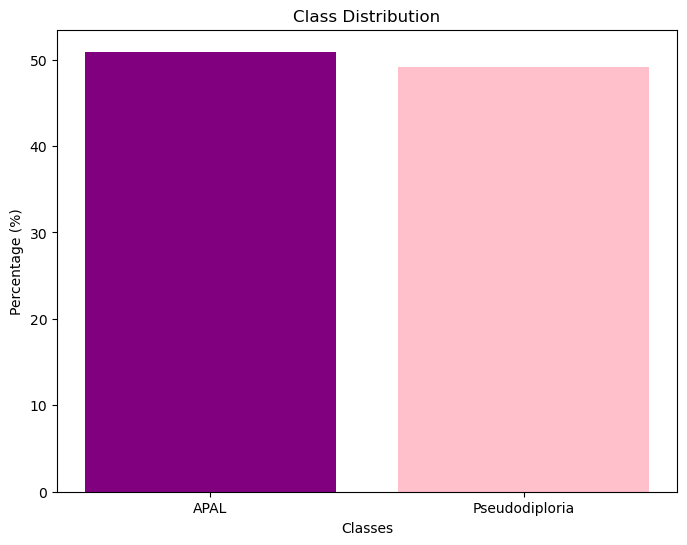

In [17]:
import matplotlib.pyplot as plt

# Calculate class percentages
class_percentages = class_counts / len(labels) * 100

# Create a bar plot showing class distribution
plt.figure(figsize=(8, 6))
plt.bar(unique_labels, class_percentages, color=['purple', 'pink'])
plt.xlabel('Classes')
plt.ylabel('Percentage (%)')
plt.title('Class Distribution')
plt.show()


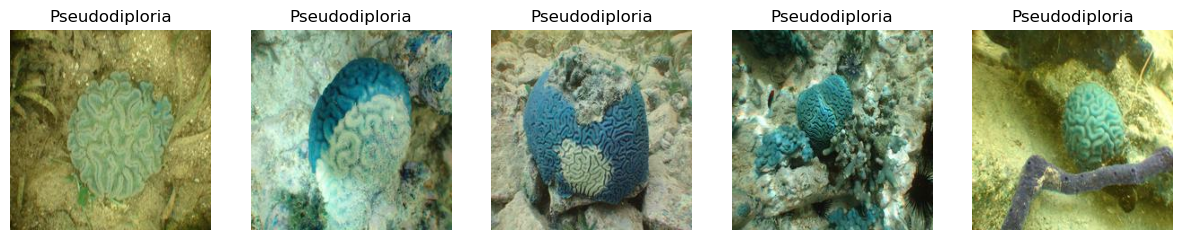

In [18]:
import matplotlib.pyplot as plt

# Define the number of samples to display
num_samples_to_display = 5

# Create subplots to display the images
plt.figure(figsize=(15, 5))

for i in range(num_samples_to_display):
    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis("off")

plt.show()


In [19]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
# Check the shape of the training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (1276, 224, 224, 3)
y_train shape: (1276,)
X_test shape: (319, 224, 224, 3)
y_test shape: (319,)


In [20]:
# Save your data to a pickle file
with open('../data/external/data_vgg16.pkl', 'wb') as f:
    pickle.dump((X_train, y_train, X_test, y_test), f)

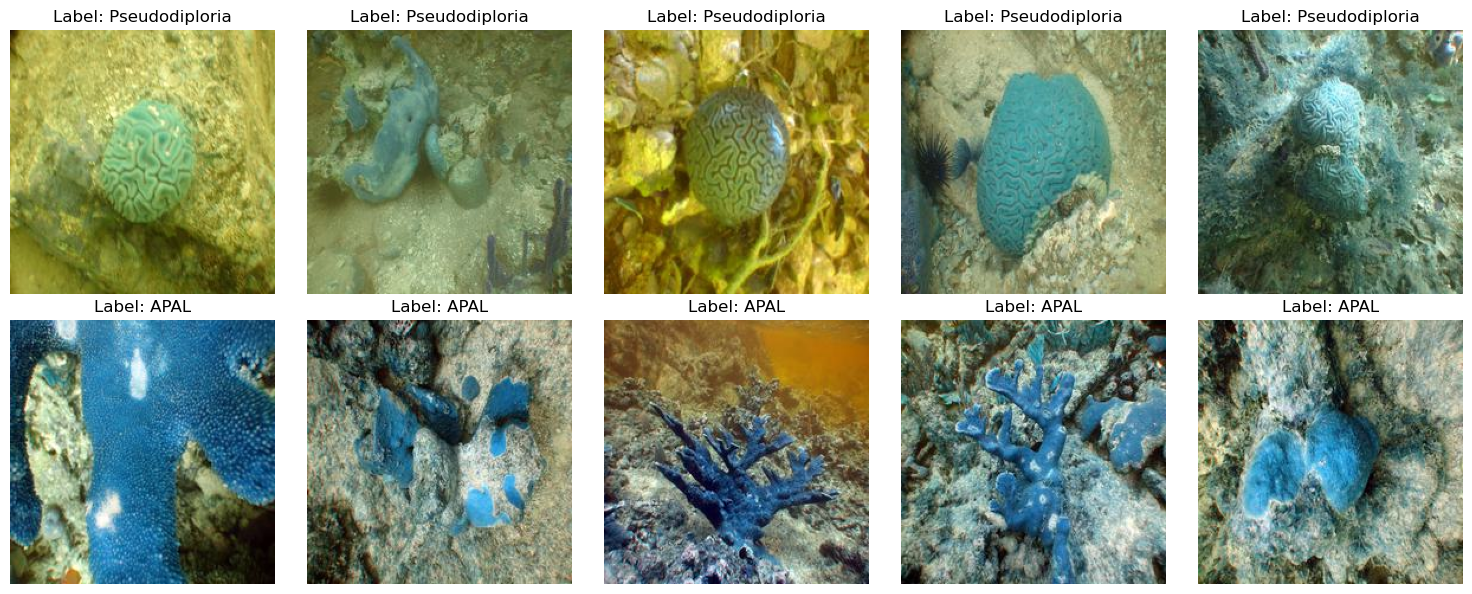

In [21]:
import random

# Define the number of rows and columns for the grid
num_rows = 2
num_columns = 5

# Define the target classes
target_classes = ["Pseudodiploria", "APAL"]

# Initialize variables to count how many images have been selected for each class
class_counts = {class_label: 0 for class_label in target_classes}

# Create subplots for displaying the selected images and labels
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 6))
axes = axes.ravel()

for i, class_label in enumerate(target_classes):
    for j in range(num_columns):
        # Find the indices of all samples in the training set with the target class label
        class_indices = [idx for idx, label in enumerate(y_train) if label == class_label]
        
        # Shuffle the class_indices to randomly select images
        random.shuffle(class_indices)
        
        # Ensure we don't select more images than available
        if class_counts[class_label] < len(class_indices):
            # Get the index of the image to display
            selected_index = class_indices[class_counts[class_label]]
            
            # Display the selected image and label
            axes[i * num_columns + j].imshow(X_train[selected_index])
            axes[i * num_columns + j].set_title(f'Label: {class_label}')
            axes[i * num_columns + j].axis("off")
            
            # Increment the count for this class
            class_counts[class_label] += 1

plt.tight_layout()
plt.show()


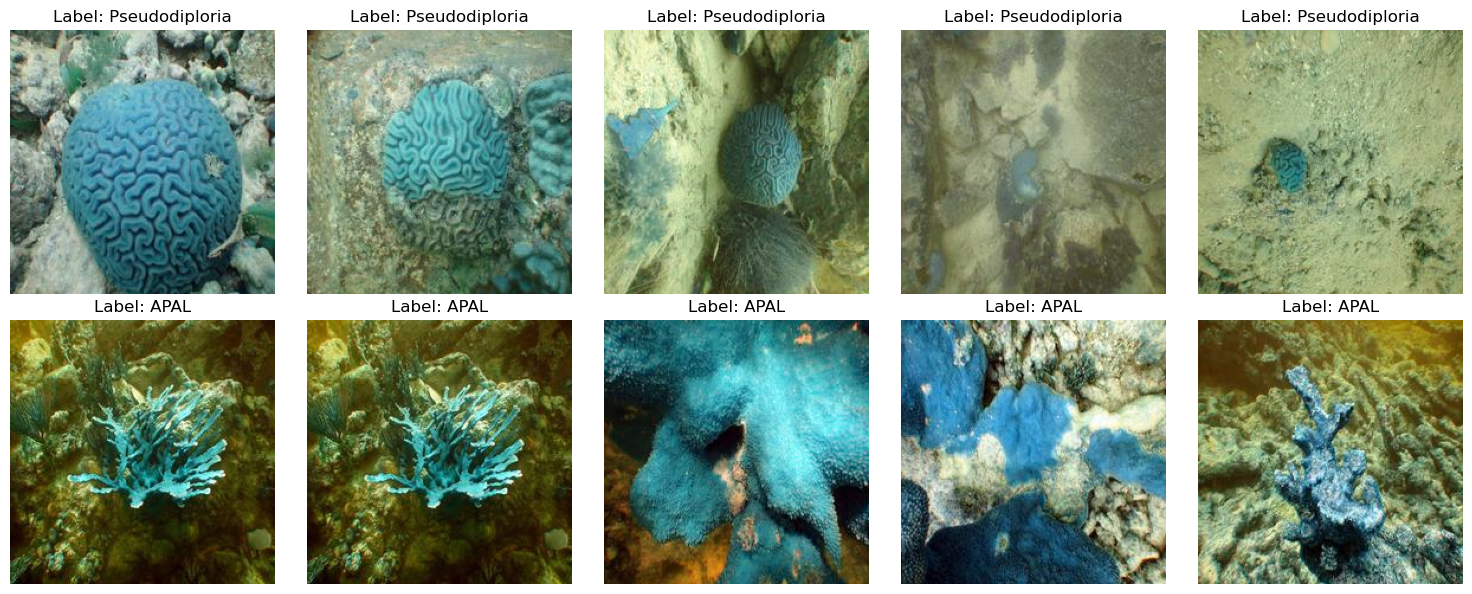

In [22]:
# Create subplots for displaying the selected test images and labels
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 6))
axes = axes.ravel()

for i, class_label in enumerate(target_classes):
    for j in range(num_columns):
        # Find the indices of all samples in the test set with the target class label
        class_indices = [idx for idx, label in enumerate(y_test) if label == class_label]
        
        # Ensure we don't select more images than available
        if class_counts[class_label] < len(class_indices):
            # Get the index of the image to display
            selected_index = class_indices[class_counts[class_label]]
            
            # Display the selected test image and label
            axes[i * num_columns + j].imshow(X_test[selected_index])
            axes[i * num_columns + j].set_title(f'Label: {class_label}')
            axes[i * num_columns + j].axis("off")
            
            # Increment the count for this class
            class_counts[class_label] += 1

plt.tight_layout()
plt.show()


In [23]:
# Load your data from the pickle file
with open('../data/external/data_vgg16.pkl','rb') as f:
    X_train,y_train,X_test,y_test = pickle.load(f)

# Check the shapes
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1276, 224, 224, 3)
y_train shape: (1276,)
X_test shape: (319, 224, 224, 3)
y_test shape: (319,)
